# Seatle and Boston Airbnb Open Data
## Exploratory Data Analysis

**Author:** Paola Rocha  
**Date:** March 3rd, 2024

**Description**  
The objective of this notebook is to answers business questions for [Boston](https://www.kaggle.com/datasets/airbnb/boston?select=calendar.csv) and [Seatle](https://www.kaggle.com/datasets/airbnb/seattle?resource=download) Airbnb Open Data. 

Este notebook se enfocarà en responder las siguientes preguntas para cada una de las ciudades:
1. Dònde se encuentran los superhosts?
    - Utilizar el dataset de listing con longitud y latitud
    - Utilizar el precio con escala de colores para mostrar superhost mas costosos.
2. Què cualidades de la habitaciòn afectan màs para ser un superhost?
3. Què tipo de reviews tienen los superhosts?
    - Usar NPL para describir los reviews.
4. Predicciòn de precios promedios para la siguiente temporada de super hosts.
    - Existe una diferencia de tendencias para los que no son superhosts?

**Notebook contents**
1. Libraries
2. Dataset description
3. Data acquistion
4. Cleaning data
5. Saving data

In [1]:
# Processing data
from pandas import pandas as pd

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading data
seatle_listings = pd.read_csv('../data/processed/Seatle/listings.csv', dtype={'host_is_superhost': bool})
boston_listings = pd.read_csv('../data/processed/Boston/listings.csv', dtype={'host_is_superhost': bool})

## 1. Dònde se encuentran principalmente los superhosts?

### Hosts ubication

In [3]:
def pivot_listings(df_listings):
    """This function group data by neighbourhood and host type ('host' or 'superhost').
    Also, get the count of airbnb hosts and the average price cost by accommodation.

    Args:
        df_listings (pd.DataFrame): Listing dataframe

    Returns:
        pd.DataFrame: Dataframe with count of hosts and average price by host type.
    """
    # Grouping by host and neighbourhood and getting the average price
    df_neighbourhood = df_listings.groupby(by=['host_is_superhost', 'neighbourhood']).agg({'price':'mean', 'id':'count'}).reset_index()
    
    # Separation by host type
    neighbour_host = df_neighbourhood[df_neighbourhood['host_is_superhost'] == False].drop('host_is_superhost', axis=1)
    neighbour_superhost = df_neighbourhood[df_neighbourhood['host_is_superhost'] == True].drop('host_is_superhost', axis=1)
    
    # Merging dataframes
    df_neighbour_pivot = neighbour_host.merge(neighbour_superhost, on='neighbourhood', how='outer', suffixes=('_host', '_superhost')).fillna(0).sort_values('price_host')
    return df_neighbour_pivot

In [4]:
# Grouping by host and neighbourhood and getting the average bas price
seattle_neighbour_pivot = pivot_listings(seatle_listings)
boston_neighbour_pivot = pivot_listings(boston_listings)

In [5]:
def vbar_host_comparison(df_pivot, column_name:str, title:str):

    df_pivot = df_pivot.sort_values(f'{column_name}_host')

    y = list(range(len(df_pivot)))

    fig = go.Figure(data=[
        go.Bar(y=y, x=df_pivot[f'{column_name}_superhost'], orientation='h', name="Superhost", base=0),
        go.Bar(y=y, x=-df_pivot[f'{column_name}_host'], orientation='h', name="Host", base=0),
    ])

    fig.update_layout(
        barmode='stack',
        title={'text': f"<b>{title}</b><br>Host vs Superhost",
            'x':0.5,
            'xanchor': 'center'
        },
        width=1000,
        height=1000,
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=50,
            pad=0
        ),)

    fig.update_yaxes(
            ticktext=df_pivot['neighbourhood'],  # Updating y axis names with neighbourhood names
            tickvals=y
        )
    fig.show()

In [6]:
vbar_host_comparison(seattle_neighbour_pivot, 'id', 'How many Airbnbs are by host in Seattle by neighbourhood?')

In [7]:
vbar_host_comparison(boston_neighbour_pivot, 'id', 'How many Airbnbs are by host in Boston by neighbourhood?')

In [8]:
def geographical_price(df_listings, host_is_superhost:bool):
    """Filter listings dataframe by host type and calculate the average of price by coordenates.

    Args:
        df_listings (pd.DataFrame): Listings dataframe
        host_is_superhost (bool): Type of host. If True, host is superhost, otherwise is only a host

    Returns:
        pd.DataFrame: Dataframe with the coordenates and average price.
    """
    df_listings_filtered = df_listings[df_listings['host_is_superhost'] == host_is_superhost]
    df_coords = df_listings_filtered.groupby(by=['latitude', 'longitude']).agg({'price': 'mean'}).reset_index()
    return df_coords

In [9]:
def mapbox_price(df_coords, color_continuous_scale:str='matter'):
    fig = px.density_mapbox(df_coords, lat='latitude', lon='longitude', z='price', radius=15, zoom=0, color_continuous_scale='matter')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [10]:
seattle_superhost_coords = geographical_price(seatle_listings, host_is_superhost=True)
seattle_host_coords = geographical_price(seatle_listings, host_is_superhost=False)

In [11]:
mapbox_price(seattle_superhost_coords)

In [12]:
mapbox_price(seattle_host_coords)

In [13]:
boston_superhost_coords = geographical_price(boston_listings, host_is_superhost=True)
boston_host_coords = geographical_price(boston_listings, host_is_superhost=False)

In [14]:
mapbox_price(boston_superhost_coords)

In [15]:
mapbox_price(boston_host_coords)

## 2. Què cualidades de la habitaciòn afectan màs para ser un superhost?

In [16]:
seatle_listings.columns

Index(['id', 'name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'thumbnail_url', 'medium_url',
       'host_name', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_ni

In [17]:
seatle_listings['amenities_count'] = seatle_listings['amenities'].str.count(',') + 1
acommodation_qualities_cols = [#'host_is_superhost', # 'property_type', 'room_type',  'bed_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities_count',
       'minimum_nights', 'review_scores_cleanliness', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']
seatle_listings[acommodation_qualities_cols]

,accommodates,bathrooms,bedrooms,beds,amenities_count,minimum_nights,review_scores_cleanliness,review_scores_rating,review_scores_accuracy,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,4,1.0,1.0,1.0,10,1,10.0,95.0,10.0,10.0,10.0,9.0,10.0
1,4,1.0,1.0,1.0,16,2,10.0,96.0,10.0,10.0,10.0,10.0,10.0
2,11,4.5,5.0,7.0,21,4,10.0,97.0,10.0,10.0,10.0,10.0,10.0
3,3,1.0,0.0,2.0,14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,2.0,3.0,3.0,13,1,9.0,92.0,9.0,10.0,10.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,6,2.0,3.0,3.0,16,3,10.0,80.0,8.0,4.0,8.0,10.0,8.0
3812,4,1.0,1.0,2.0,17,2,10.0,100.0,10.0,10.0,10.0,10.0,10.0
3813,2,1.0,1.0,1.0,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3814,2,1.0,0.0,1.0,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
seatle_accomodation = seatle_listings[acommodation_qualities_cols + ["host_is_superhost"]]
seatle_accomodation['host_is_superhost'] = seatle_accomodation['host_is_superhost'].astype(int)

/var/folders/5c/k9c1xp0n28v63h44vwqygqs40000gn/T/ipykernel_2028/2007589155.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review_scores_cleanliness
0,10.0
1,10.0
2,10.0
4,9.0
5,10.0
...,...
3808,8.0
3809,8.0
3810,10.0
3811,10.0


<Axes: xlabel='review_scores_cleanliness', ylabel='host_is_superhost'>

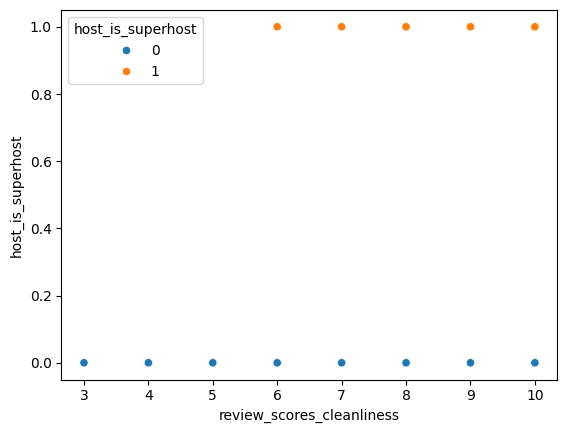

In [19]:
display(seatle_accomodation[[acommodation_qualities_cols[6]]].dropna(axis=0))
sns.scatterplot(data=seatle_accomodation.dropna(axis=0), x=acommodation_qualities_cols[6], y="host_is_superhost", hue="host_is_superhost")

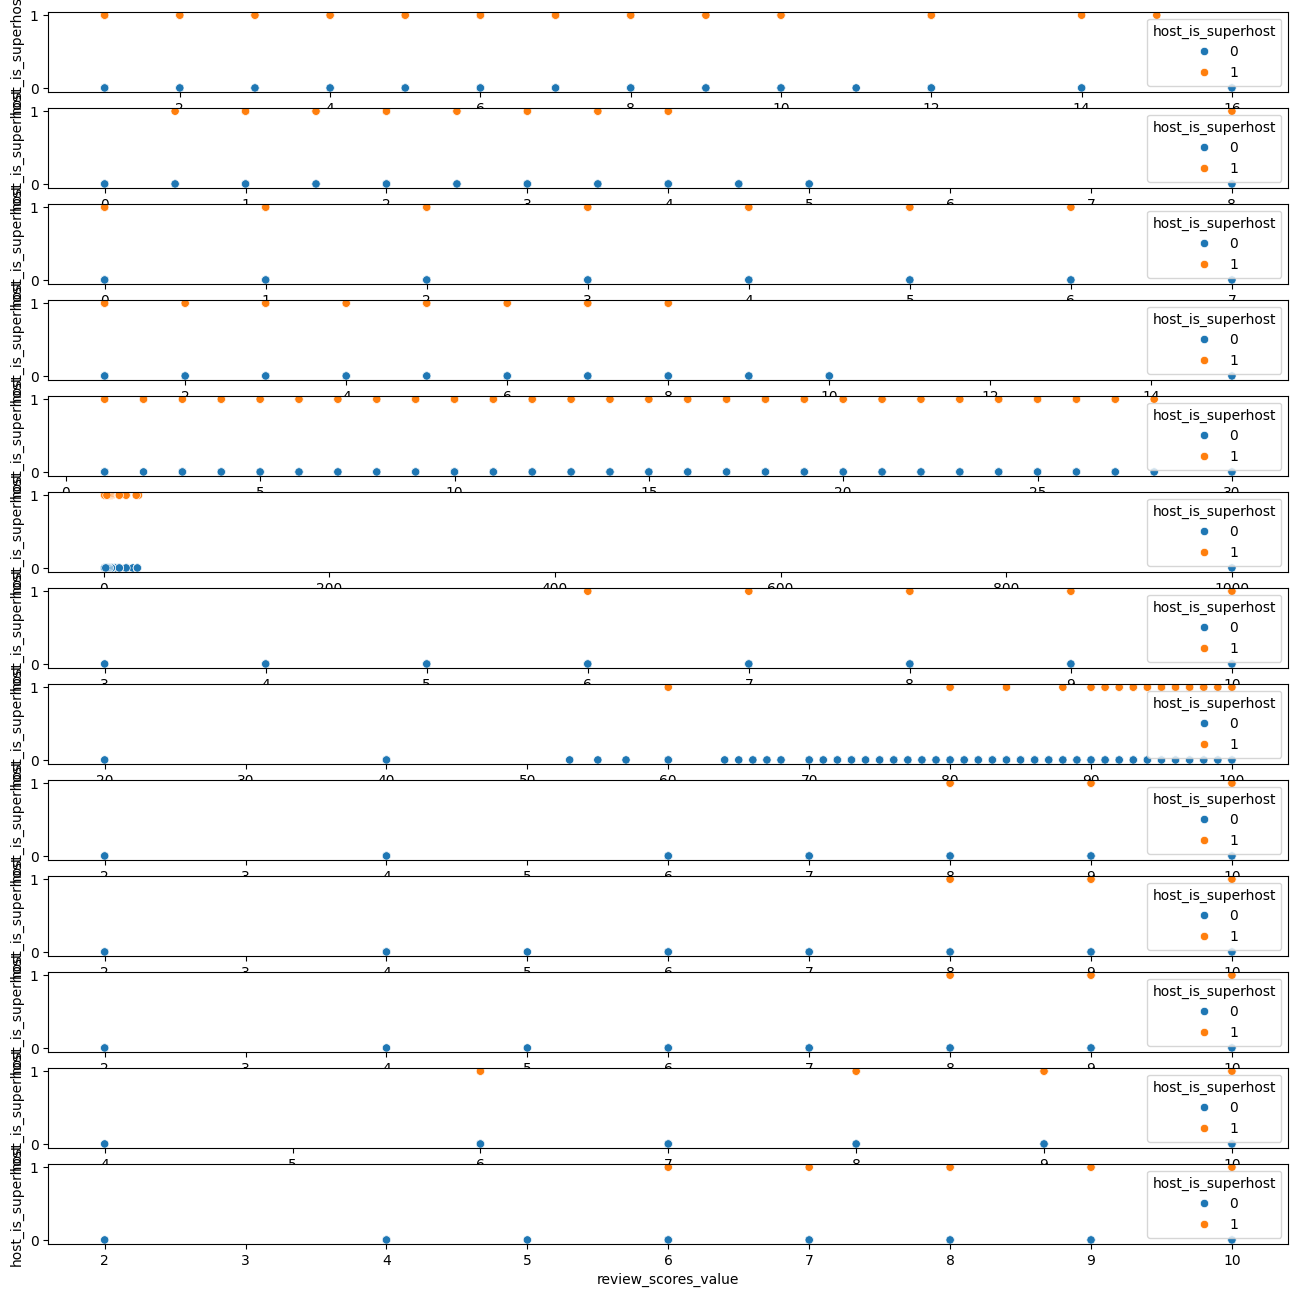

In [24]:
fig, axs = plt.subplots(nrows=len(acommodation_qualities_cols), sharey=True, figsize=(16,16))

for idx, column in enumerate(acommodation_qualities_cols):
    sns.scatterplot(data=seatle_accomodation.dropna(axis=0), x=column, y="host_is_superhost", hue="host_is_superhost", ax=axs[idx])

KeyError: "['Goals_PerGame'] not in index"

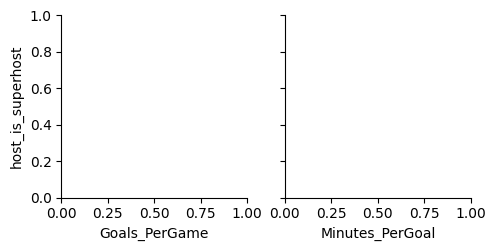

In [21]:
# sns.pairplot(seatle_accomodation.dropna(axis=0), y_vars=['host_is_superhost'], x_vars=['Goals_PerGame', 'Minutes_PerGoal'], hue="host_is_superhost")